In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyTVDN.tmpUtils import *
%matplotlib inline

In [3]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def SmoothEst(self):
        if self.nYmat is None:
            self._Preprocess()
        d, n = self.nYmat.shape
        acTime = n / self.paras.freq
        self.ptime = np.linspace(0, acTime, n)
        self.time = np.linspace(0, self.paras.T, n)
        divNum = 100
        if self.smoothType == "bspline":
            self.dXmat = np.zeros((d, n))
            self.Xmat = np.zeros((d, n))
            if n%divNum == 0:
                numLoop = int(n/divNum)
            else:
                numLoop = int(n/divNum) + 1
            for i in range(numLoop):
                if (i+1)*divNum <= n:
                    low = i*divNum
                    up = (i+1)*divNum
                else:
                    low = i*divNum
                    up = n
                self.dXmat[:, low:up], self.Xmat[:, low:up] = GetBsplineEst(self.nYmat[:, low:up], self.time[low:up], 
                                                                            lamb=self.paras.lamb)
        elif self.smoothType == "fourier":
            self.dXmat, self.Xmat = GetFourierEst(self.nYmat, self.time, nbasis=self.paras.nbasis)

In [4]:
resDir = Path("../results")
dataDir = Path("../data/MEG_DKRegion_TimeCourses")

In [5]:
datFils = list(dataDir.glob("*.mat"))
datFils

[PosixPath('../data/MEG_DKRegion_TimeCourses/lcmv_result_R2868E_02-st_DKregion10.mat'),
 PosixPath('../data/MEG_DKRegion_TimeCourses/lcmv_result_R2868E_02-st_DKregion20.mat'),
 PosixPath('../data/MEG_DKRegion_TimeCourses/lcmv_result_R2868E_02-st_DKregionmin.mat'),
 PosixPath('../data/MEG_DKRegion_TimeCourses/lcmv_result_R2868E_03-st_DKregion10.mat'),
 PosixPath('../data/MEG_DKRegion_TimeCourses/lcmv_result_R2868E_03-st_DKregion20.mat'),
 PosixPath('../data/MEG_DKRegion_TimeCourses/lcmv_result_R2868E_03-st_DKregionmin.mat')]

In [6]:
gtFs = list(dataDir.glob("*.txt"))
gtSt02 = time2pts(txt2Time(gtFs[0]), timeLims.st02)

In [9]:
txt2Time(gtFs[0])

[39.4625,
 48.0791666667,
 59.2841666667,
 70.8908333333,
 81.3258333333,
 92.7041666667]

In [10]:
gtSt02

{'ts': array([ 4.4625    , 13.07916667, 24.28416667, 35.89083333, 46.32583333,
        57.70416667]), 'cpts': array([ 535, 1569, 2914, 4306, 5559, 6924])}

In [11]:
from scipy.signal import lfilter, firls, decimate

In [12]:
q = 10

## Plot the data

In [13]:
idx = 1
print(datFils[idx])

../data/MEG_DKRegion_TimeCourses/lcmv_result_R2868E_02-st_DKregion20.mat


In [14]:
MEG = loadmat(datFils[idx])

In [15]:
data = MEG["DK_timecourse"]

The time course is 60 seconds, so the frequency is 1200 Hz

In [16]:
d, n = data.shape

### Four sample sequences of the data

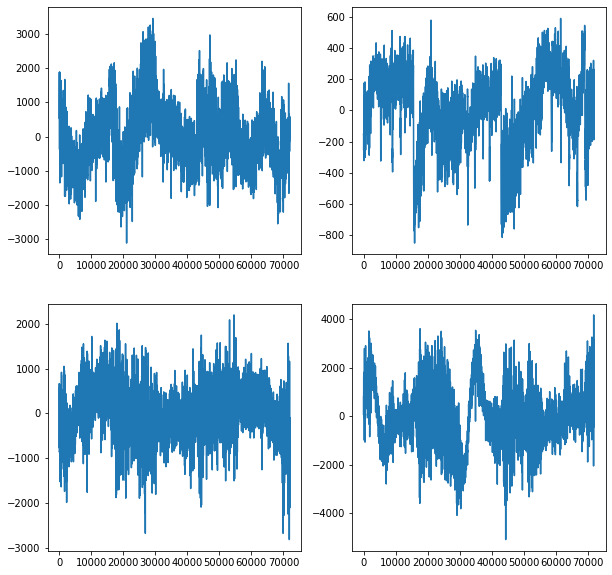

In [17]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.plot(data[1, :])

plt.subplot(222)
plt.plot(data[5, :])

plt.subplot(223)
plt.plot(data[15, :])

plt.subplot(224)
plt.plot(data[45, :])

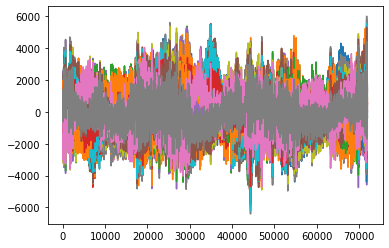

In [18]:
for i in range(d):
    plt.plot(data[i, :])

###  Data preprocessing

In [19]:
dataN = decimate(data, q=q)

In [20]:
dataN = detrend(dataN)

### HPF 

In [21]:
fs = 120 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 60])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass

In [22]:
dataHPF = lfilter(hbp, 1, dataN)

### Four sequences of the data after HPF

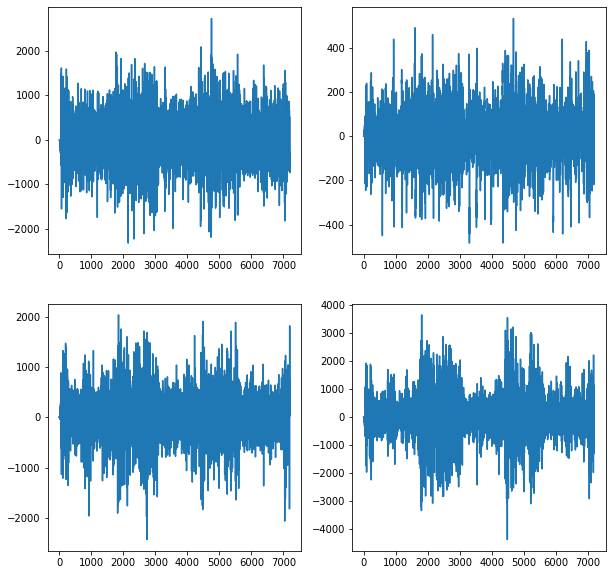

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.plot(dataHPF[1, :])

plt.subplot(222)
plt.plot(dataHPF[5, :])

plt.subplot(223)
plt.plot(dataHPF[15, :])

plt.subplot(224)
plt.plot(dataHPF[45, :])

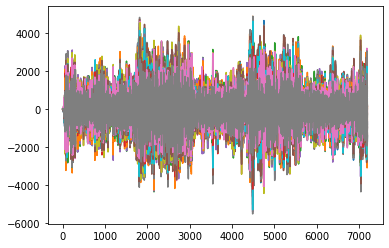

In [24]:
for i in range(d):
    plt.plot(dataHPF[i, :])

## Detection on data without HPF

In [25]:
paras = edict()
paras.Lmin = 100
paras.wh = 10
paras.MaxM = 20
paras.fct = 0.5
paras.r = 8
paras.freq = 120
paras.lamb = 1e-4
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = 1
paras.downRate = 20

In [26]:
detRaw = TVDNDetect(Ymat=dataN, dataType="MEG", 
                     saveDir=datFils[idx].stem, 
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 100,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 8}


In [27]:
detRaw.Screening(wh=paras.wh)

In [28]:
detRaw()

/home/huaqingj/MyResearch/TVDN/pyTVDN/TVDNclass.py:266: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)


In [29]:
kappas = np.linspace(1, 4, 1000)

In [30]:
detRaw.TuningKappa(kappas)

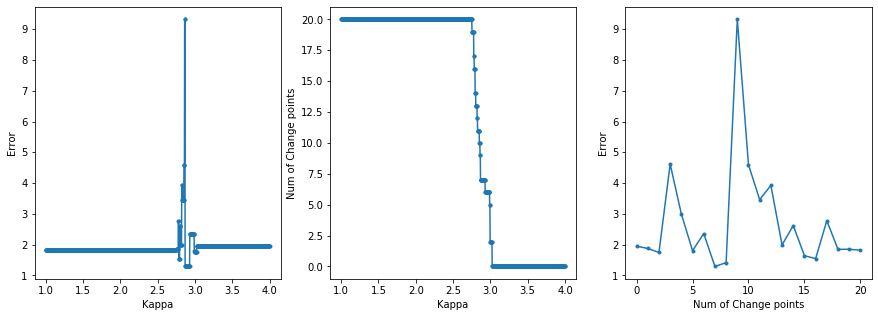

In [31]:
detRaw.PlotKappaErrCurve()

In [32]:
detRaw.UpdateEcpts()

In [33]:
print(detRaw)

+-------------+---------------------------------------------+-------------------+------+
| Num of CPTs |                Estiamted CPTs               |        MSE        | Rank |
+-------------+---------------------------------------------+-------------------+------+
|      7      | [ 883. 1482. 2011. 2646. 3387. 4233. 6034.] | 1.288802297046123 |  8   |
+-------------+---------------------------------------------+-------------------+------+


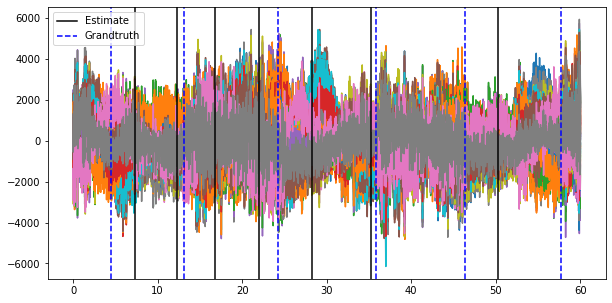

In [34]:
detRaw.PlotEcpts(GT=gtSt02.cpts)

In [35]:
detRaw.UpdateEcpts(len(gtSt02.cpts))

In [36]:
print(detRaw)

+-------------+---------------------------------------+--------------------+------+
| Num of CPTs |             Estiamted CPTs            |        MSE         | Rank |
+-------------+---------------------------------------+--------------------+------+
|      6      | [ 809. 2011. 2646. 3387. 4233. 6034.] | 2.3563390040056897 |  8   |
+-------------+---------------------------------------+--------------------+------+


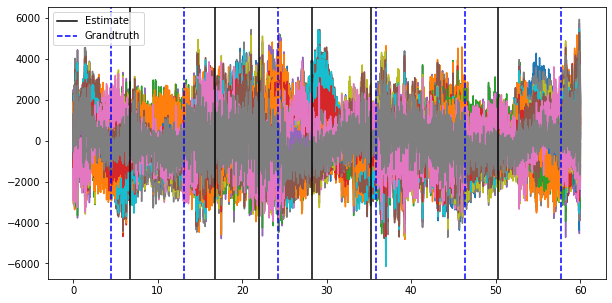

In [37]:
detRaw.PlotEcpts(GT=gtSt02.cpts)

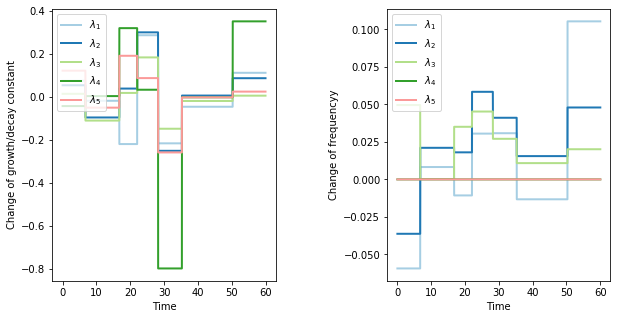

In [38]:
detRaw.PlotEigenCurve()

The plot indices are [51 15 33 23 62].


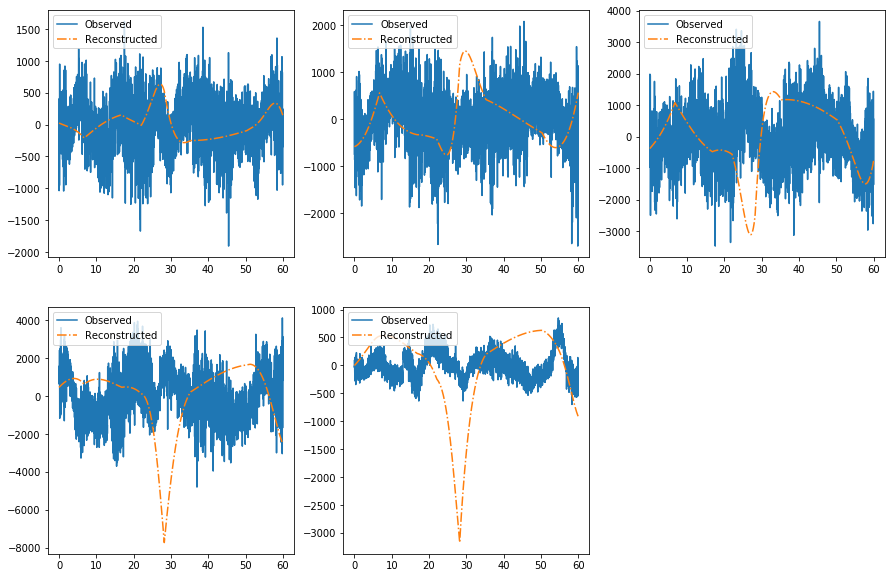

array([51, 15, 33, 23, 62])

In [39]:
detRaw.PlotRecCurve()

## Detection after HPF 

In [40]:
detHPF = TVDNDetect(Ymat=dataHPF, dataType="MEG", 
                     saveDir=None, 
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 100,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 8}


In [41]:
detHPF.Screening(wh=paras.wh)

In [42]:
detHPF()

In [43]:
kappas = np.linspace(1, 4, 1000)

In [44]:
detHPF.TuningKappa(kappas)

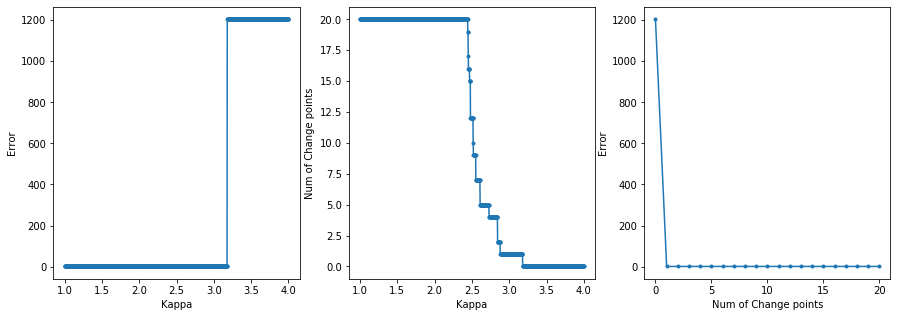

In [45]:
detHPF.PlotKappaErrCurve()

In [46]:
detHPF.UpdateEcpts()

In [47]:
print(detHPF)

+-------------+----------------+--------------------+------+
| Num of CPTs | Estiamted CPTs |        MSE         | Rank |
+-------------+----------------+--------------------+------+
|      1      |    [6988.]     | 0.9850383321204321 |  8   |
+-------------+----------------+--------------------+------+


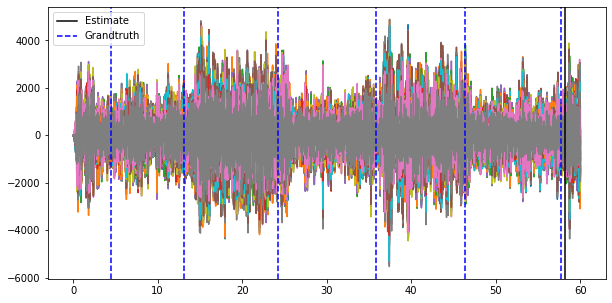

In [48]:
detHPF.PlotEcpts(GT=gtSt02.cpts)

In [49]:
detHPF.UpdateEcpts(len(gtSt02.cpts))

In [50]:
print(detHPF)

+-------------+---------------------------------------+--------------------+------+
| Num of CPTs |             Estiamted CPTs            |        MSE         | Rank |
+-------------+---------------------------------------+--------------------+------+
|      6      | [1338. 2539. 3919. 4914. 6281. 6988.] | 0.9980891672633989 |  8   |
+-------------+---------------------------------------+--------------------+------+


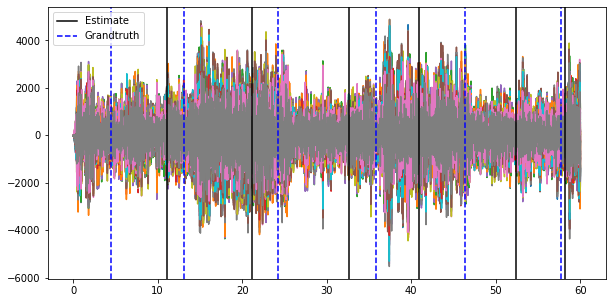

In [51]:
detHPF.PlotEcpts(GT=gtSt02.cpts)

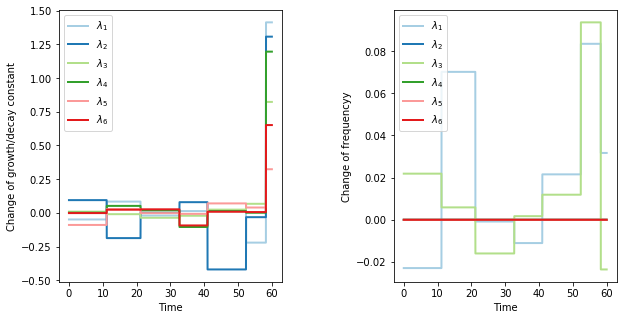

In [52]:
detHPF.PlotEigenCurve()

The plot indices are [39 58 46 66 28].


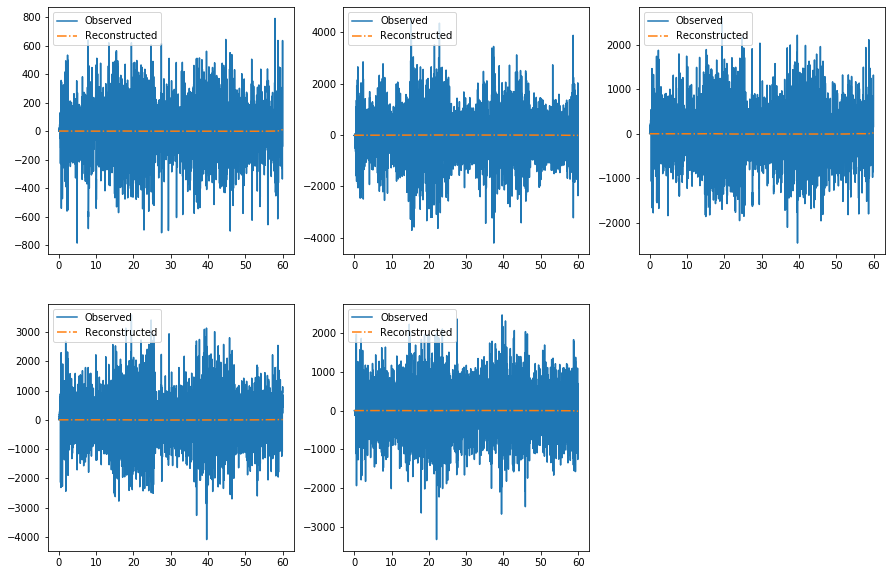

array([39, 58, 46, 66, 28])

In [53]:
detHPF.PlotRecCurve()